In [1]:
import random
import time
import math
import numpy as np

import torch
from torchtext import data

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import seaborn as sns
# sns.set() Problems with attention

from seq2seq import utils


## Static encodings

One of the problems of using another embedding layer to encode the positional embeddings is that you cannot expand
the maximum length supported by the model at training time.

This happens because positions *1,2,3...* are encoded as the vocabulary of the embedding layer. Therefore, if we
expand our vocabulary, we need to retrain our model.

Luckily, there is a simple solution to this problem... Encoding positions with a static function. Here, I'll use the
function presented in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) which mixes sines and
cosines.

In [2]:
def positional_encodings(model_d, max_len):
    # Compute the positional encodings once in log space.
    pe = torch.zeros(max_len, model_d)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, model_d, 2) * -(math.log(10000.0) / model_d))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.cpu()

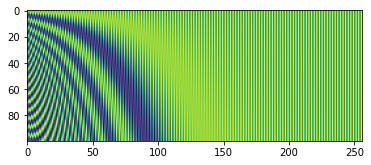

In [3]:
%matplotlib inline

pos_enc = positional_encodings(model_d=256, max_len=100)
plt.imshow(pos_enc)

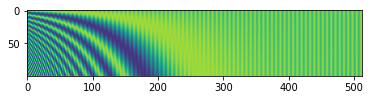

In [4]:
%matplotlib inline

pos_enc = positional_encodings(model_d=512, max_len=100)
plt.imshow(pos_enc)

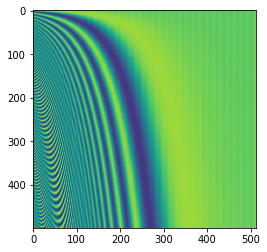

In [5]:
%matplotlib inline

pos_enc = positional_encodings(model_d=512, max_len=500)
plt.imshow(pos_enc)


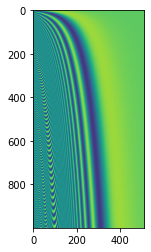

In [6]:
%matplotlib inline

pos_enc = positional_encodings(model_d=512, max_len=1000)
plt.imshow(pos_enc)

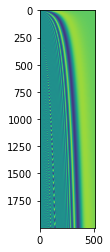

In [7]:
%matplotlib inline

pos_enc = positional_encodings(model_d=512, max_len=2000)
plt.imshow(pos_enc)


## Learned encodings



### Define model


In [8]:
# Build model and initialize
DATASET_NAME = "miguel"  # multi30k, miguel
DATASET_PATH = f"../../.data/{DATASET_NAME}"
ALLOW_DATA_PARALLELISM = False
MAX_SRC_LENGTH = 100 + 2  # Doesn't include <sos>, <eos>
MAX_TRG_LENGTH = 100 + 2  # Doesn't include <sos>, <eos>
MAX_TRG_LENGTH_TEST = int(MAX_TRG_LENGTH * 1.0)  # len>1.0 is not supported by all models
BATCH_SIZE = 32
CHECKPOINT_PATH = f'../checkpoints/simple_transformer_2.pt'
TS_RATIO = 1.0
SOS_WORD = '<sos>'
EOS_WORD = '<eos>'
EVALUATE = True
BLUE = True

### Load vocabularies

In [9]:
# Set fields
SRC = data.Field(tokenize='spacy', tokenizer_language="en", init_token=SOS_WORD, eos_token=EOS_WORD, lower=True, batch_first=True)
TRG = data.Field(tokenize='spacy', tokenizer_language="es", init_token=SOS_WORD, eos_token=EOS_WORD, lower=True, batch_first=True)
fields = [('src', SRC), ('trg', TRG)]

/home/salvacarrion/anaconda3/envs/mltests/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/salvacarrion/anaconda3/envs/mltests/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [10]:
# Load vocabulary
src_vocab = utils.load_vocabulary(f'{DATASET_PATH}/tokenized/src_vocab.pkl')
trg_vocab = utils.load_vocabulary(f'{DATASET_PATH}/tokenized/trg_vocab.pkl')

# Add vocabularies to fields
SRC.vocab = src_vocab
TRG.vocab = trg_vocab


In [11]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(utils.gpu_info())


from seq2seq.models import s2s_6_transfomer as builder
model = builder.make_model(src_field=SRC, trg_field=TRG,
                           max_src_len=MAX_SRC_LENGTH, max_trg_len=MAX_TRG_LENGTH, device=device,
                           data_parallelism=ALLOW_DATA_PARALLELISM)


- Using GPU: True
- No. devices: 1
- Device name (0): GeForce GTX 1070
The model has 11,695,888 trainable parameters
Data parallelism: False


### Plot positional embeddings (Encoder)

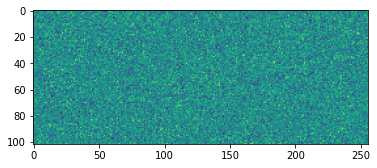

In [12]:
%matplotlib inline

# Encoder: Positional encodings
enc_pos_emb = model.encoder.pos_embedding.weight.detach().cpu()
plt.imshow(enc_pos_emb)


### Plot word embeddings (Encoder)

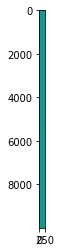

In [13]:
%matplotlib inline

# Encoder: Positional encodings
enc_word_emb = model.encoder.tok_embedding.weight.detach().cpu()
plt.imshow(enc_word_emb)

### Plot positional embeddings (Decoder)

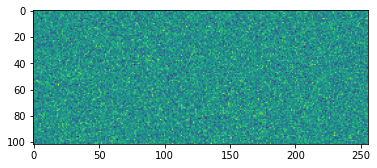

In [14]:
%matplotlib inline

# Encoder: Positional encodings
dec_pos_emb = model.decoder.pos_embedding.weight.detach().cpu()
plt.imshow(dec_pos_emb)

### Plot word embeddings (Decoder)

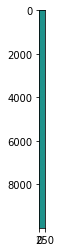

In [15]:
%matplotlib inline

# Encoder: Positional encodings
dec_word_emb = model.decoder.tok_embedding.weight.detach().cpu()
plt.imshow(dec_word_emb)
